
### Multi-slice Angular Spectrum for scalar wave simulation of volumetric object
#### or   
### SHIFT + Skew based Efficient 2.5D Optic simulation    


2025.02.17 Yonsei - OISL 
contact : Yong Guk Kang
- Single-slice AS (off-axis) : geometric(Ray-optic) artifact
- Multi-slice AS (Off-axis) : Simulate geometric(Ray-optic) artifact
- Single-slice AS (Off-axis) with skewed heightmap : Simulate geometric(Ray-optic) artifact

* Goal 1 : measure the discrepancy between Single slice and Multi slice model, to validate the effect of geometrical distortion
* Goal 2 : Single slice AS based propagation model to simulate geometrical distortion from non 2D optics
* skewed heightmap has no relation with sampling rate  

Multi-slice Angular Spectrum methods were referenced from : 
https://github.com/Ni-Chen/multi-slice-beam-propagation-matlab?tab=readme-ov-file

* Heightmap skew : 
입사각도 따른 Warping 구현
SkewedHeightmap(x0, y0) = heightmap(x1, y1)   
[x1, y1] = [x0, y0]+[dx, dy]
Lens direction 반영 : dx = -dx or dx = -dx

* 2025.02.27    
Shifted Prop kernel fix!!! dz/nMat가 아니라, k0*nMat로 수정
Prop ( k0*nMat, dz)  --> 거의 Generalized 됨    

Huygens PSF와 모양 바뀌는 트렌드가 매칭 됨
크기는 아직 안됨... 왜??

* 2025.02.28 
OPD Elongation 적용 : 이제 어느정도 써먹을 수 있음

* 2025. 03.04
Multi-slice 모델이 GT(Huygens)와 매칭되는 조건 및 증거 자료 획득중   
1. Mask Thickness 고려하기 : mask 두께만큼 propagation --> On axis에서 매칭됨
2. Off axis에서 OPD 늘어나는것 + 굴절 고려하기 : --> Off axis에서 매칭됨

todo : 
1. Multi-slice Off axis matching : OPD Elongation  
2. single-slice On axis matching : Defining numerical Principal plane   
3. single-slice Off axis matching : Heightmap Skew   
이제 Basic은 쓸 필요 없음

WPM(nMat기반? binary mask 추가 적용해야 완전함), MSDP(nAir기반), 객체지향적(?)으로 변경


2025.03.14.
* Multislice(nMat기반) 잘 작동
Propagator : arcsin(sin(xDeg)/nMat), Ko*n, dzSkew 
SkewCorrector : sqrt(1 + tan(arcsin(sin(xRad) / nMat)) ** 2     
shiftX = -(((fLens + dz_shift + (thicknessMask/nMat)) * torch.tan(xRad)) / simPxSize)
* Skew heightmap (nMat기반) 잘 작동
Propagator : arcsin(sin(xDeg)/nMat), Ko*n, dzSkew 
HeightmapSkewed = S.heightmapSkew(maskHeightmap, simPxSize, torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), WD, sourceType=sourceType, heightmapDirection=heightmapDirection)
skew 중 index offset = Max height or 0
SkewCorrector : sqrt(1 + tan(arcsin(sin(xRad) / nMat)) ** 2     
shiftX = -(((fLens + dz_shift + (thicknessMask/nMat)) * torch.tan(xRad)) / simPxSize)



거의 잘 작동 

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import math
import os
import datetime
import pickle
import tifffile
import numpy as np
import h5py

### Angular spectrum 관련 및 편의성 관련 
import asmethod as S
from asmethod import FT, IFT


torch.set_default_dtype(torch.float64) # float32 --> aliasing
plt.rcParams['image.cmap'] = 'viridis'

## CUDA setting
GPU_number = 2  # device want to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_number)

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_func = F.mse_loss


cuda


In [2]:

def estimate_principal_plane(heightmap, n_lens, n_air=1.0):
    """
    Estimate the principal plane position from a lens heightmap.
    
    Args:
        heightmap (torch.Tensor): 2D tensor of the lens heightmap (thickness at each pixel).
        simPxSize (float): Physical size of a single pixel (in meters).
        n_lens (float): Refractive index of the lens material.
        n_air (float): Refractive index of air (default is 1.0).
    
    Returns:
        float: Estimated principal plane position relative to the vertex.
    """
    # Convert heightmap to physical distances

    # Compute the effective thickness of the lens (weighted mean of heightmap)
    heightmap_mean = torch.mean(heightmap)  # Mean thickness
    heightmap_max = torch.max(heightmap)  # Maximum thickness
    heightmap_min = torch.min(heightmap)  # Minimum thickness
    T_eff = (heightmap_mean + heightmap_max) / 2  # Approximate effective thickness

    # Apply principal plane formula
    P_est = T_eff * (n_air / n_lens)
    return P_est

def postProcess(inputField, shiftX, shiftY, upScaleFactor, maskNy=0, maskNx=0):
    outputIntensity = torch.abs(inputField) ** 2
    outputIntensity = torch.clamp(torch.real(S.subpixel_shift(outputIntensity, shiftX, shiftY)), min=0).cpu()
    outputIntensity = S.imageResize(outputIntensity, 1 / upScaleFactor)
    if maskNy != 0 and maskNx != 0:
        outputIntensity = S.imageCropPad(outputIntensity, target_size=[maskNy, maskNx])
    return outputIntensity

class SimulationResult:
    """ 시뮬레이션 결과 저장 클래스 """
    def __init__(self, name, field):
        self.name = name
        self.field = field
        self.norm_field = self.normalize(field)

    def normalize(self, field):
        """ Min-max 정규화 """
        field = field - torch.min(field)
        return field / (torch.max(field) + 1e-6)

    def diff(self, other):
        """ 두 결과 간의 차이 계산 """
        return self.norm_field - other.norm_field
    
class SimulationLoop:
    def __init__(self, sweep_variable, sweep_values, label_template, huygens_reference=None, xDeg=0.0, yDeg=0.0, dz_shift=0.0):
        """
        sweep_variable: 변경할 변수 이름 (예: "xDeg", "dz_shift")
        sweep_values: 변수의 변화값 (torch.linspace)
        label_template: 라벨 템플릿 (f-string)
        huygens_reference: Huygens PSF 데이터 (None이면 포함하지 않음)
        xDeg, yDeg: 기본 X/Y축 각도 (Tensor로 변환)
        dz_shift: 기본 dz 이동 값 (Tensor로 변환)
        """
        self.sweep_variable = sweep_variable
        self.sweep_values = sweep_values
        self.label_template = label_template
        self.huygens_reference = huygens_reference
        self.huygens_available = huygens_reference is not None  # ✅ Huygens PSF 사용 여부
        self.xDeg = torch.tensor(xDeg)  
        self.yDeg = torch.tensor(yDeg)  
        self.dz_shift = torch.tensor(dz_shift)  
        self.results = []

    def run(self):
        for ind, value in enumerate(self.sweep_values):
            setattr(self, self.sweep_variable, value.clone().detach())  
            sweep_label = self.label_template.format(value=value.item())

            # 필드 설정
            xRad = self.xDeg * (torch.pi / 180)  
            yRad = self.yDeg * (torch.pi / 180)  
            dz_shift = self.dz_shift 
            
            self.skewDistCorr2 = torch.sqrt(1 + torch.tan(torch.arcsin(torch.sin(xRad) / nMat)) ** 2 + torch.tan(torch.arcsin(torch.sin(yRad) / nMat)) ** 2)         

            shiftX = -(((fLens + dz_shift + (thicknessMask/nMat)) * torch.tan(xRad)) / simPxSize)
            shiftY = -(((fLens + dz_shift + (thicknessMask/nMat)) * torch.tan(yRad)) / simPxSize)

            # Source field 설정
            inField_normal = S.sourceField(XX, YY, torch.tensor(0), torch.tensor(0), WD, k0, sourceType=sourceType).to(device)

            # Propagation Operators 설정
            # propOp_tppMaskFirst= S.propASKernel(FX, FY, torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), k0*nMat, (thicknessMask-pImgPlane)).to(device)
            # propOp_tppMaskLast = S.propASKernel(FX, FY,torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), k0*nMat, pImgPlane).to(device)
            
            propOp_tppMaskFirst= S.propASKernel(FX, FY,  xRad, yRad,  k0, (thicknessMask-pImgPlane)).to(device)
            propOp_tppMaskLast = S.propASKernel(FX, FY,  xRad, yRad,  k0, pImgPlane).to(device)
  
            propOp_toSensor = S.propASKernel(FX, FY, xRad, yRad, k0, flangeDist).to(device)
            propOp_dzShift = S.propASKernel(FX, FY, xRad, yRad, k0, self.dz_shift).to(device)

            propOp_tSliceHalf_air = S.propASKernel(FX, FY, xRad, yRad, k0, dz_mask*0.5).to(device)
            propOp_tSliceFull_air = S.propASKernel(FX, FY, xRad, yRad, k0, dz_mask).to(device)

            propOp_tSliceHalf_mat = S.propASKernel(FX, FY, torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), k0*nMat, dz_mask * 0.5).to(device)
            propOp_tSliceFull_mat = S.propASKernel(FX, FY, torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), k0*nMat, dz_mask).to(device)


            # ✅ Huygens PSF 불러오기 (존재할 경우만)
            huygens_result = None
            if self.huygens_available:
                huygens = self.huygens_reference[:, :, ind].clone()
                cropNy, cropNx = int(maskNy * 0.1), int(maskNx * 0.1)
                huygens_result = postProcess(huygens, 0, 0, 1, 0, 0)  

            # ✅ WPM 및 MSDP에서 첫 번째 마스크 적용 후 전파
            shift_result = self.run_shift(inField_normal.clone(), propOp_toSensor, propOp_dzShift, propOp_tppMaskFirst, propOp_tppMaskLast)
            # msdp_result = self.run_msdp(inField_normal.clone(), propOp_toSensor, propOp_dzShift, propOp_tSliceHalf_air, propOp_tSliceFull_air)
            skshp_result = self.run_skshp(inField_normal.clone(), propOp_toSensor, propOp_dzShift, propOp_tppMaskFirst, propOp_tppMaskLast, xRad, yRad)
            wpm_result = self.run_wpm(inField_normal.clone(), propOp_toSensor, propOp_dzShift, propOp_tSliceHalf_mat, propOp_tSliceFull_mat)

            cropNy, cropNx = int(maskNy * 0.1), int(maskNx * 0.1)
            shift_result = postProcess(shift_result, shiftX, shiftY, upScaleFactor, cropNy, cropNx)
            skshp_result = postProcess(skshp_result, shiftX, shiftY, upScaleFactor, cropNy, cropNx)
            # msdp_result = postProcess(msdp_result, shiftX, shiftY, upScaleFactor, cropNy, cropNx)
            wpm_result = postProcess(wpm_result, shiftX, shiftY, upScaleFactor, cropNy, cropNx)

            shift_result = postProcess(shift_result, 0, 0, 1/2, 0, 0)
            # msdp_result = postProcess(msdp_result, 0, 0, 1/2, 0, 0)
            wpm_result = postProcess(wpm_result, 0, 0, 1/2, 0, 0)
            skshp_result = postProcess(skshp_result, 0, 0, 1/2, 0, 0)

            # ✅ SimulationResult 클래스를 사용하여 저장
            results_list = [
                SimulationResult(f"Shift AS {sweep_label}", shift_result),
                SimulationResult(f"Skew AS+PP {sweep_label}", skshp_result),
                # SimulationResult(f"MSDP {sweep_label}", msdp_result),
                SimulationResult(f"WPM {sweep_label}", wpm_result)
            ]
            
            if self.huygens_available:
                results_list.insert(0, SimulationResult(f"Huygens {sweep_label}", huygens_result))

            self.results.append(results_list)


    def run_skshp(self, field, propOp_toSensor, propOp_dzShift, propOp_tppMaskFirst, propOp_tppMaskLast, xRad, yRad):
        """ Shifted AS + Heightmap Skew + PP 시뮬레이션 실행 """
        # maskHeightmapSkewed = S.heightmapSkew(maskHeightmap, simPxSize, xRad, yRad, WD, sourceType=sourceType, heightmapDirection=heightmapDirection, pImgPlane=pImgPlane)
        maskHeightmapSkewed = S.heightmapSkew(maskHeightmap, simPxSize, torch.arcsin(torch.sin(xRad) / nMat), torch.arcsin(torch.sin(yRad) / nMat), WD, sourceType=sourceType, heightmapDirection=heightmapDirection)
        maskSkew = torch.exp(1j * (maskHeightmapSkewed * self.skewDistCorr2 * k0 * (nMat - n0))) * maskAperture

        field = IFT(FT(field) * propOp_tppMaskFirst)  # half prop
        field *= maskSkew  # Apply Mask
        field = IFT(FT(field) * propOp_tppMaskLast)  # half prop
        return IFT(FT(field) * propOp_toSensor * propOp_dzShift)  # single step prop toward sensor

    def run_shift(self, field, propOp_toSensor, propOp_dzShift, propOp_tppMaskFirst, propOp_tppMaskLast):
        """ Shift AS 시뮬레이션 실행 """
        maskShift = torch.exp(1j * (maskHeightmap * self.skewDistCorr2 * k0 * (nMat - n0))) * maskAperture
        field = IFT(FT(field) * propOp_tppMaskFirst)  # half prop
        field *= maskShift
        field = IFT(FT(field) * propOp_tppMaskLast)  # half prop
        return IFT(FT(field) * propOp_toSensor * propOp_dzShift)

    def run_msdp(self, field, propOp_toSensor, propOp_dzShift, propOp_tSliceHalf_air, propOp_tSliceFull_air):
        """ MSDP 시뮬레이션 실행 (Slice별 Iterative 적용) """
        # ✅ 첫 번째 마스크 적용 후 전파 시작 // DistCorr 해줘야 통통해짐
        maskMsdp = torch.exp(1j * self.skewDistCorr2 * k0 * (normHeightmapSliced[:, :, 0] * (nMat - n0)) * dz_mask) * maskAperture
        field = IFT(FT(field) * propOp_tSliceHalf_air)
        field *= maskMsdp

        for indM in range(numSliced - 1):
            maskMsdp = torch.exp(1j * self.skewDistCorr2 * k0 * ((normHeightmapSliced[:, :, indM + 1]) * (nMat - n0)) * dz_mask) * maskAperture
            field = IFT(FT(field) * propOp_tSliceFull_air) * maskMsdp
        
        field = IFT(FT(field) * propOp_tSliceHalf_air)
        return IFT(FT(field) * propOp_toSensor * propOp_dzShift)

    def run_wpm(self, field, propOp_toSensor, propOp_dzShift, propOp_tSliceHalf_mat, propOp_tSliceFull_mat):
        """ WPM 시뮬레이션 실행 (Slice별 Iterative 적용) """
        # ✅ 첫 번째 마스크 적용 후 전파 시작
        maskWpm = torch.exp(-1j * self.skewDistCorr2 * k0 * ((1 - normHeightmapSliced[:, :, 0]) * (nMat - n0)) * dz_mask) * maskAperture
        field = IFT(FT(field) * propOp_tSliceHalf_mat)
        field *= maskWpm

        for indM in range(numSliced - 1):
            maskWpm = torch.exp(-1j * self.skewDistCorr2 * k0 * ((1 - normHeightmapSliced[:, :, indM + 1]) * (nMat - n0)) * dz_mask) * maskAperture
            field = IFT(FT(field) * propOp_tSliceFull_mat) * maskWpm
        
        field = IFT(FT(field) * propOp_tSliceHalf_mat)
        return IFT(FT(field) * propOp_toSensor * propOp_dzShift)

def plot_simulations(simulations, sweep_labels, method_names=None, num_cols=5):
    """
    Huygens PSF 포함 여부에 따라 시뮬레이션 결과를 시각화하며, 모든 플롯의 중간 Line Profile을 추가하여 비교.

    Args:
        simulations (list): 시뮬레이션 결과 리스트 (각 sweep별 [Huygens?, Shift AS, MSDP, WPM, Skew AS+PP])
        sweep_labels (list): 각 시뮬레이션의 Sweep Label
        method_names (list): 사용된 시뮬레이션 방법 이름 리스트 (예: ["Huygens", "Shift AS", "MSDP", "WPM", "Skew AS+PP"])
        num_cols (int): 플롯의 열 개수 (기본값: 5)
    """

    num_sweeps = len(sweep_labels)
    num_methods = len(simulations[0])  

    if method_names is None:
        method_names = ["Shift AS",  "Skew AS+PP", "WPM"]  # 기본값 (Huygens 없음)
    
    huygens_available = "Huygens" in method_names
    num_rows = num_methods + (num_methods - 1 if huygens_available else 0) + 1  # 마지막 줄에 Line Profile 추가

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6), constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
    fig.suptitle(f"Comparison of Different Propagation Methods Including Huygens PSF \n optic DimX:{(opticDimX/mm):.2f}mm', ", fontweight="bold", fontsize=num_cols * 5)

    for ind, (sweep_label, results) in enumerate(zip(sweep_labels, simulations)):
        norm_fields = [result.norm_field for result in results]

        # ------------- 원본 이미지 플롯 -------------
        for row_idx, (img, title) in enumerate(zip(norm_fields, method_names)):
            im = axs[row_idx, ind].imshow(img.cpu(), cmap="viridis", vmax=torch.max(img))
            axs[row_idx, ind].set_title(f"Method: {title}\nSweep Parameter: {sweep_label}")
            axs[row_idx, ind].set_aspect("equal")
            fig.colorbar(im, ax=axs[row_idx, ind], fraction=0.05, pad=0.04)

        # ------------- Huygens PSF과의 차이 플롯 (Huygens 제공 시) -------------
        if huygens_available:
            for row_idx in range(1, num_methods):
                diff_img = norm_fields[row_idx] - norm_fields[0]  
                im = axs[num_methods + row_idx - 1, ind].imshow(diff_img.cpu(), cmap="seismic", vmin=-0.5, vmax=0.5)
                axs[num_methods + row_idx - 1, ind].set_title(f"Difference: {method_names[row_idx]} - Huygens\nSweep: {sweep_label}")
                axs[num_methods + row_idx - 1, ind].set_aspect("equal")
                fig.colorbar(im, ax=axs[num_methods + row_idx - 1, ind], fraction=0.05, pad=0.04)

        # ------------- 모든 플롯의 중앙 Line Profile을 추가 -------------
        center_row = norm_fields[0].shape[0] // 2
        center_col = norm_fields[0].shape[1] // 2

        for idx, (img, name) in enumerate(zip(norm_fields, method_names)):
            profile = img[center_row-1:center_row, int(center_col*0.15):int(center_col*0.85)]
            profile = torch.mean(profile, dim=0).cpu().numpy()
            profile = (profile - profile.min()) / (profile.max() - profile.min() + 1e-10)  # Normalize
            axs[num_rows - 1, ind].plot(profile, label=name)  

        axs[num_rows - 1, ind].legend()
        axs[num_rows - 1, ind].set_title(f"Central Line Profile Comparison\nSweep Parameter: {sweep_label}")
        axs[num_rows - 1, ind].set_xlabel("X Pixel")
        axs[num_rows - 1, ind].set_ylabel("Normalized Intensity")

    plt.savefig(f"Simulation_Results.png", dpi=300)
    plt.show()



In [3]:


# 단위 변환 설정
floatoffset = 0
cm = 10**-(2+floatoffset)
mm = 10**-(3+floatoffset)
um = 10**-(6+floatoffset)
dmdPxSize = 0.8 * um
label = datetime.datetime.now().strftime("[%y%m%d][%H%M%S]")

# Sampling rate 설정
upScaleFactor = 1
padFactor = 2
# (1) Optical Field 설정
WD = 500 * cm  # Working Distance
xDegMax = torch.Tensor([40])
yDegMax = torch.Tensor([30])
sourceType = 'Plane'

# Optical Mask 설정
n0, nMat = 1.0, 1.54
wavelen = torch.tensor(0.55 * um)
k0 = 2 * torch.pi / wavelen
fLens = torch.tensor(3.5955 * mm)
# fLens = torch.tensor(3.660 * mm)

# Field parameter 설정
maskNy, maskNx = [1280, 1280]
simPxSize = dmdPxSize / upScaleFactor
simNx, simNy = int(maskNx * upScaleFactor * padFactor), int(maskNy * upScaleFactor * padFactor)
dims = torch.tensor([simNx * simPxSize, simNy * simPxSize])
dimX, dimY = dims.tolist()
opticDimX, opticDimY = (simNx * simPxSize) / padFactor, (simNy * simPxSize) / padFactor

print(f'optic DimX:{opticDimX/um:2.2f}um')
print(f"Input Field Sampling Rate : {simPxSize/um:2.2f}um")

# Grid 설정
XX, YY = S.image_grid(dimX, dimY, simNx, simNy)
FX, FY = S.fourier_grid(dimX, dimY, simNx, simNy)

# Spherical Lens 설정
ROC = 2 * mm
addThick = 100 * um
heightmapDirection = 'Front' 
maskHeightmap, f_req = S.spherical_lens_by_radius(XX, YY, torch.tensor(opticDimX), torch.tensor(nMat), torch.tensor(ROC))
maskAperture = (maskHeightmap > 0).float()
maskHeightmap = maskHeightmap + addThick * maskAperture

print(f"Estimated f_lens : {f_req/mm:2.2f}mm")

# Multi-slice 설정
thicknessMask = torch.max(maskHeightmap) - torch.min(maskHeightmap)
print(f'thickness Mask : {thicknessMask/um:2.2f}um')

# numSlices = 30
numSlices = torch.ceil(thicknessMask / (1*wavelen/(nMat-n0))).int() 

maskHeightmapSliced, numSliced, dz_mask = S.heightmapSliceNew(maskHeightmap, numSlices=numSlices, direction=heightmapDirection)

maskHeightmap = torch.sum(maskHeightmapSliced, dim=-1).to(device)
maskHeightmapSliced = maskHeightmapSliced.to(device)
normHeightmapSliced = maskHeightmapSliced / dz_mask
normHeightmapSliced = normHeightmapSliced.to(device)
maskAperture = maskAperture.to(device)

estPPlane=estimate_principal_plane(maskHeightmap, n_lens=1.54, n_air=1.0)
print(f' estimating the Principal plane : {estPPlane/um:2.2f}um')
# Principal Plane 계산
if heightmapDirection=='Front':
    pImgPlane = (thicknessMask)*(n0)/(nMat)

else:
    pImgPlane = 0
    
print(f'principal Plane : {pImgPlane/um:2.2f}um')
print(f'BFL of lens : {(f_req - pImgPlane)/um:2.2f}um')
print(f'mean of heightmap : {torch.mean((maskHeightmap*(nMat-n0)))/um:2.2f}um')

flangeDist = fLens.to(device)
dz_mask = dz_mask.to(device)
thicknessMask = thicknessMask.to(device)


optic DimX:1024.00um
Input Field Sampling Rate : 0.80um
Estimated f_lens : 3.70mm
thickness Mask : 166.65um
 estimating the Principal plane : 62.61um
principal Plane : 108.21um
BFL of lens : 3595.49um
mean of heightmap : 14.15um


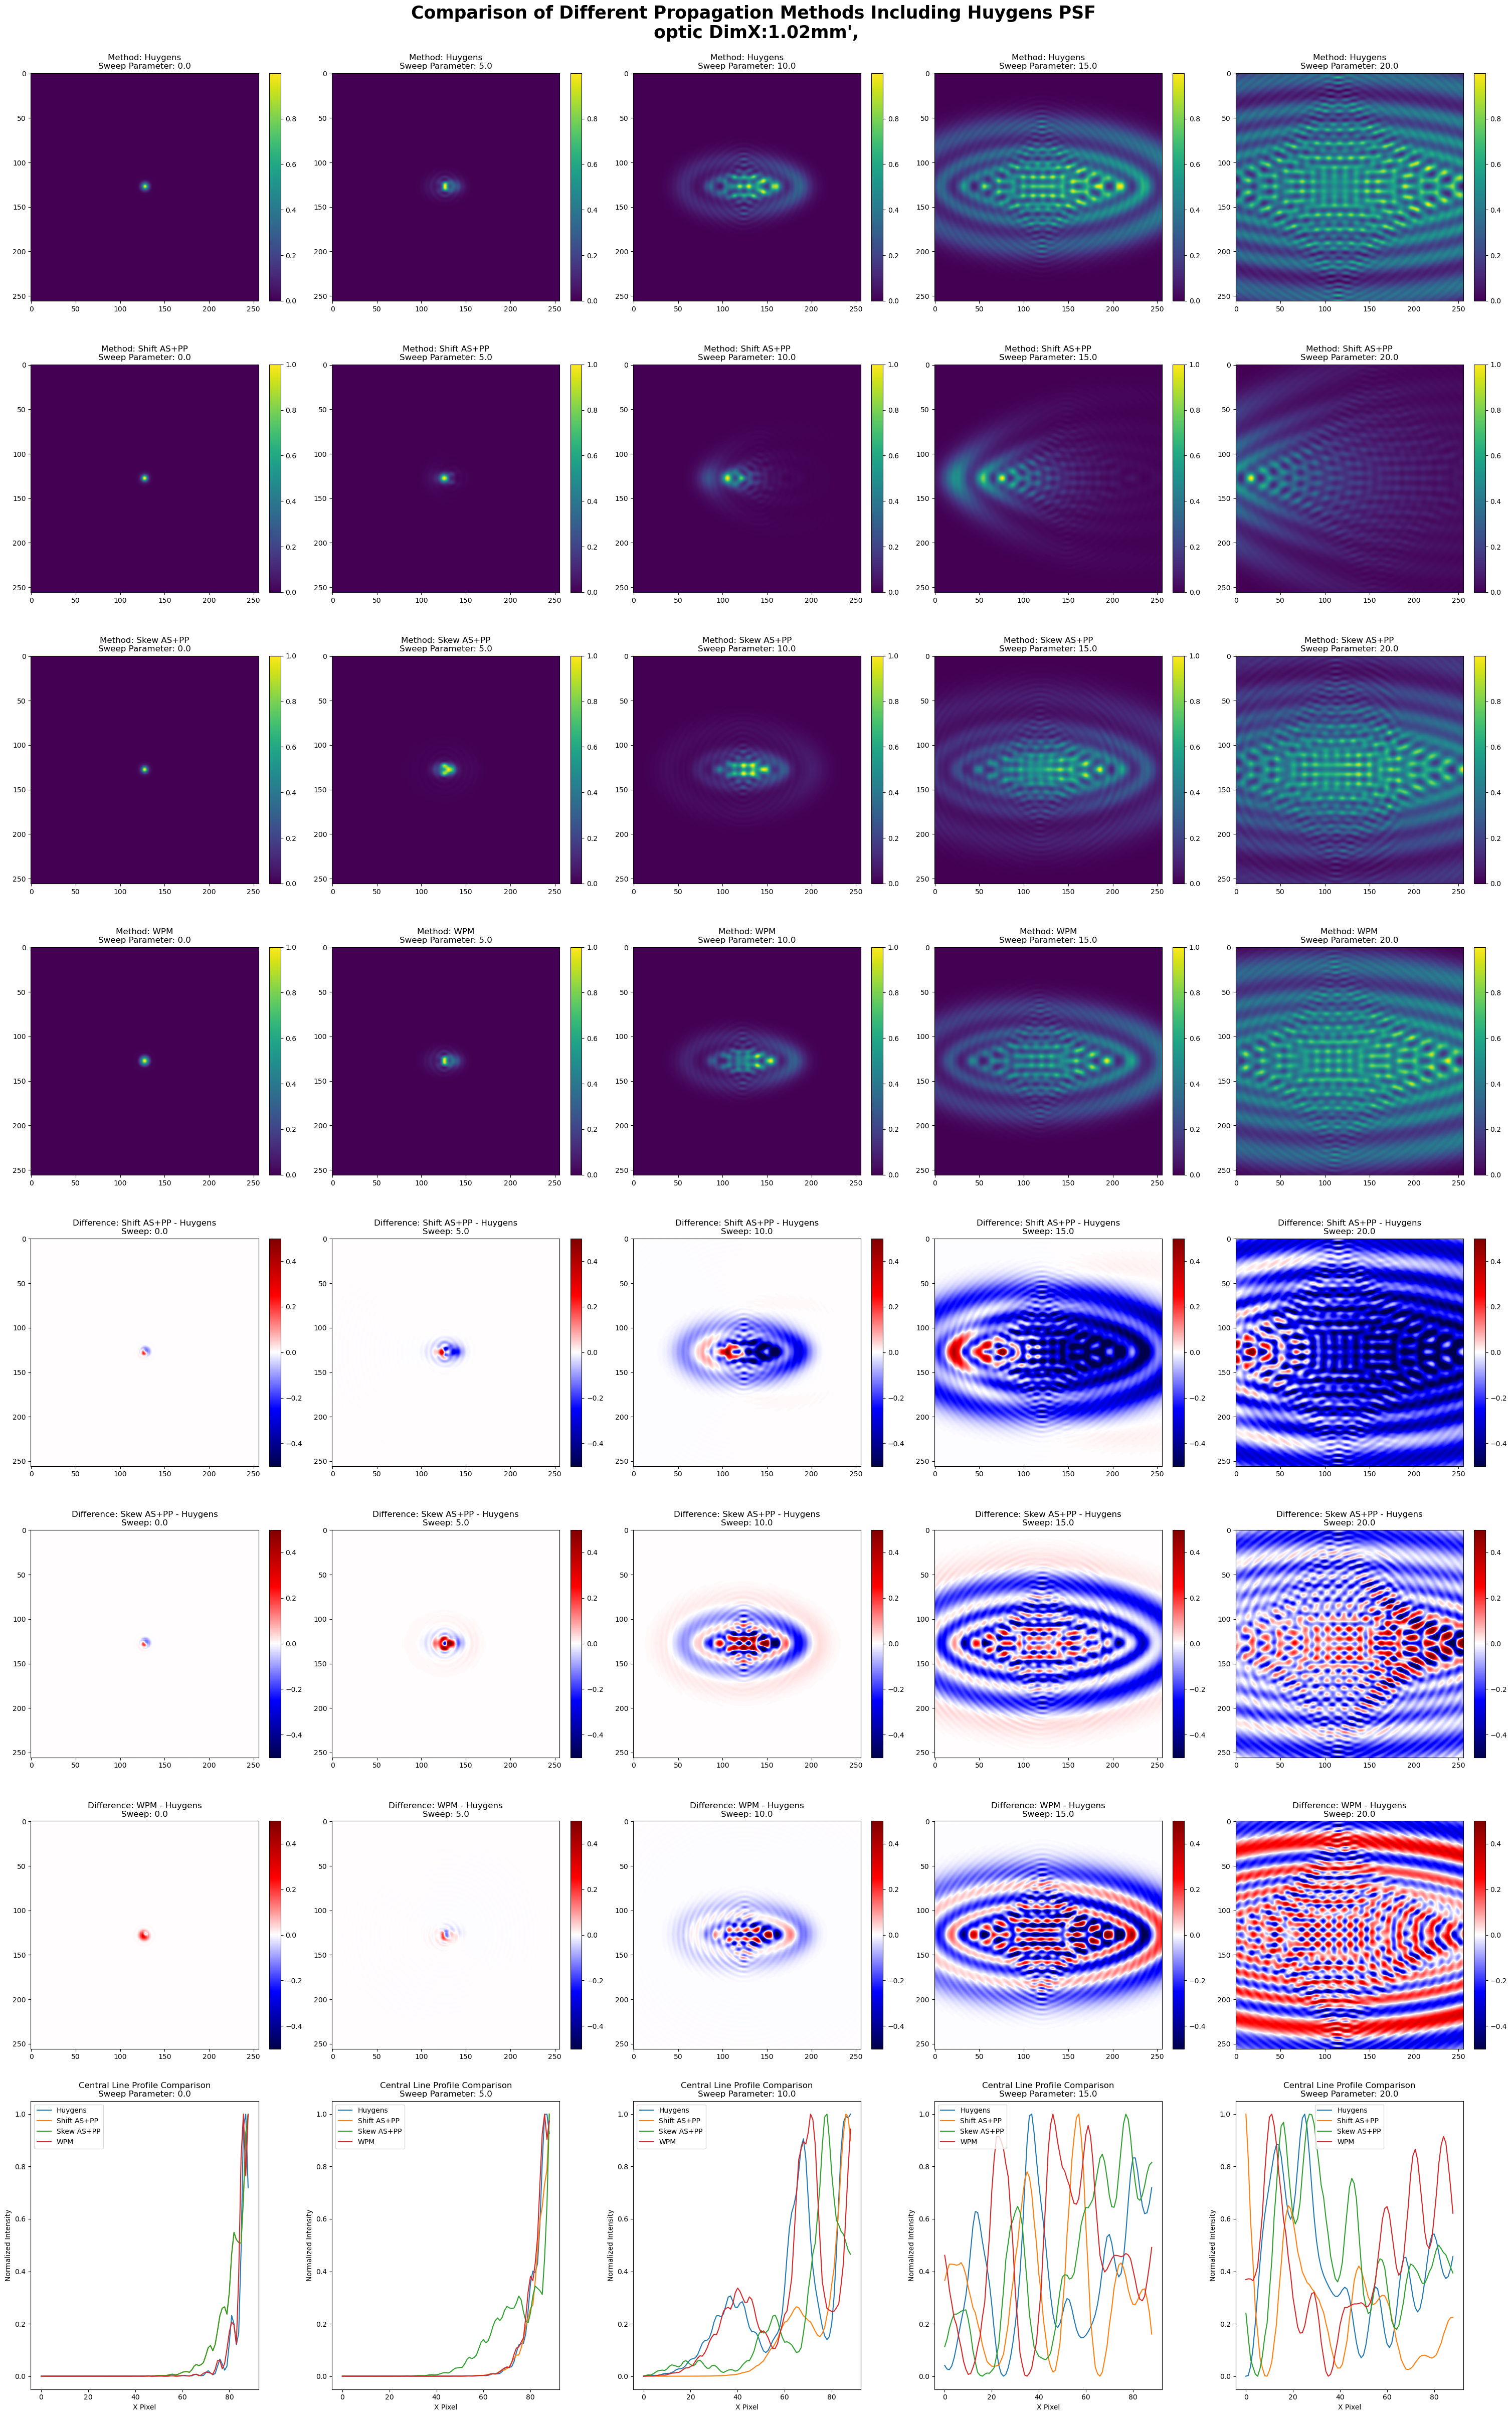

In [4]:

# 실행
# GT 불러오기 (Huygens PSF 불러오기 또는 None)
try:
    # temp = sio.loadmat('HuygensThickPSFOffaxis0to20_f31595.mat')
    temp = sio.loadmat('HuygensThickPSFOffaxis0to20_f3595.mat')
    reference = torch.tensor(temp['HuygensThickFrontPSF256ROC2Offaxis0to20']).to(device)
    reference_dx = torch.tensor(temp['pxSize']).to(device).squeeze()
except FileNotFoundError:
    reference = None  # Huygens PSF가 제공되지 않으면 None으로 설정

# Sweep 설정

numIter=5
sweep_values = torch.linspace(0, 20, numIter)  
sweep_label_template = "X {value:.2f} Deg"

# xDeg, yDeg, dz_shift
# ✅ Huygens PSF 포함 여부 자동 반영
sweep_loop = SimulationLoop("xDeg", sweep_values, sweep_label_template, reference, yDeg=0, dz_shift=0)
sweep_loop.run()
# ✅ method_names 자동 설정
method_names = ["Huygens"] if reference is not None else []
# method_names += ["Shift AS+PP", "Skew AS+PP", "MSDP", "WPM"]
method_names += ["Shift AS+PP", "Skew AS+PP", "WPM"]

plot_simulations(sweep_loop.results, sweep_loop.sweep_values, method_names, numIter)
